In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ihsgstockdata/DaftarSaham.csv
/kaggle/input/ihsgstockdata/minutes/MAPB.csv
/kaggle/input/ihsgstockdata/minutes/SIPD.csv
/kaggle/input/ihsgstockdata/minutes/ROTI.csv
/kaggle/input/ihsgstockdata/minutes/MBTO.csv
/kaggle/input/ihsgstockdata/minutes/SURE.csv
/kaggle/input/ihsgstockdata/minutes/IFII.csv
/kaggle/input/ihsgstockdata/minutes/CPIN.csv
/kaggle/input/ihsgstockdata/minutes/NASA.csv
/kaggle/input/ihsgstockdata/minutes/HAIS.csv
/kaggle/input/ihsgstockdata/minutes/MCOR.csv
/kaggle/input/ihsgstockdata/minutes/TFCO.csv
/kaggle/input/ihsgstockdata/minutes/DEWI.csv
/kaggle/input/ihsgstockdata/minutes/MLPL.csv
/kaggle/input/ihsgstockdata/minutes/KOTA.csv
/kaggle/input/ihsgstockdata/minutes/ADRO.csv
/kaggle/input/ihsgstockdata/minutes/ECII.csv
/kaggle/input/ihsgstockdata/minutes/MEDS.csv
/kaggle/input/ihsgstockdata/minutes/BINO.csv
/kaggle/input/ihsgstockdata/minutes/ISSP.csv
/kaggle/input/ihsgstockdata/minutes/TALF.csv
/kaggle/input/ihsgstockdata/minutes/YULE.csv
/kaggle/inp

# Required Library

In [2]:
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM 
from sklearn.metrics import mean_absolute_error

# Import Data

In [3]:
df = pd.read_csv('../input/ihsgstockdata/daily/ACES.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index('timestamp')
print(f"Jumlah Baris = {df.shape[0]}")
df.head()

Jumlah Baris = 3889


,open,low,high,close,volume
timestamp,,,,,
2007-11-06,98,89,102,98,1274430000
2007-11-07,98,97,103,101,349330000
2007-11-08,99,96,100,99,66270000
2007-11-09,95,95,97,95,40075000
2007-11-12,90,89,95,90,113285000


# Visualize & Transformation

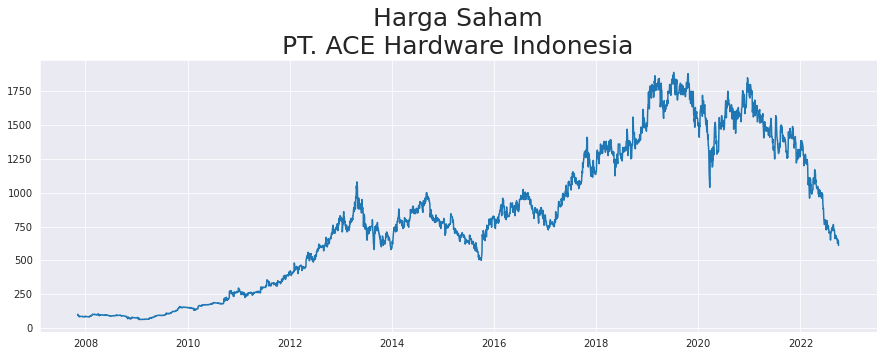

In [4]:
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')
plt.plot(df.index, df['close'])
plt.title("Harga Saham\nPT. ACE Hardware Indonesia", fontsize=25)
plt.show()

In [5]:
ms = MinMaxScaler()
df['close'] = ms.fit_transform(df[['close']])

# Split Data

In [6]:
def split_data(df, train_size): 
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [7]:
train, test = split_data(df['close'], 0.8) #80% Train

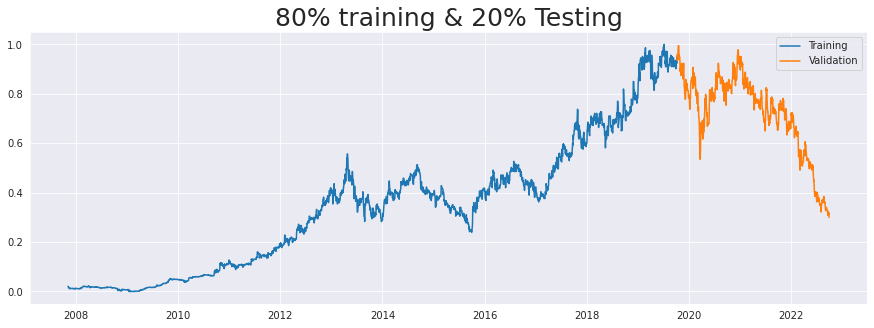

In [8]:
train, test = split_data(df['close'], 0.8) #80% Train
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Validation'])
plt.title('80% training & 20% Testing', fontsize=25)
plt.show()

In [9]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [10]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [11]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build Model

In [12]:
model = Sequential([LSTM(100, input_shape=(1, 1), return_sequences=True),
                    LSTM(50), 
                    Dense(25, activation='relu'),
                    Dense(1)])

2022-10-07 01:07:55.208431: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.015:
      self.model.stop_training = True

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())

# Training Model

In [15]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=2000, 
                    batch_size=128, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=[Callback()])

2022-10-07 01:07:55.992239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2000
25/25 [==============================] - 6s 56ms/step - loss: 0.0887 - mae: 0.3331 - val_loss: 0.2602 - val_mae: 0.7030
Epoch 2/2000
25/25 [==============================] - 0s 8ms/step - loss: 0.0835 - mae: 0.3194 - val_loss: 0.2481 - val_mae: 0.6858
Epoch 3/2000
25/25 [==============================] - 0s 8ms/step - loss: 0.0784 - mae: 0.3075 - val_loss: 0.2360 - val_mae: 0.6683
Epoch 4/2000
25/25 [==============================] - 0s 8ms/step - loss: 0.0735 - mae: 0.2966 - val_loss: 0.2240 - val_mae: 0.6504
Epoch 5/2000
25/25 [==============================] - 0s 9ms/step - loss: 0.0686 - mae: 0.2858 - val_loss: 0.2117 - val_mae: 0.6315
Epoch 6/2000
25/25 [==============================] - 0s 8ms/step - loss: 0.0637 - mae: 0.2753 - val_loss: 0.1988 - val_mae: 0.6112
Epoch 7/2000
25/25 [==============================] - 0s 8ms/step - loss: 0.0587 - mae: 0.2648 - val_loss: 0.1855 - val_mae: 0.5893
Epoch 8/2000
25/25 [==============================] - 0s 8ms/step - loss: 0

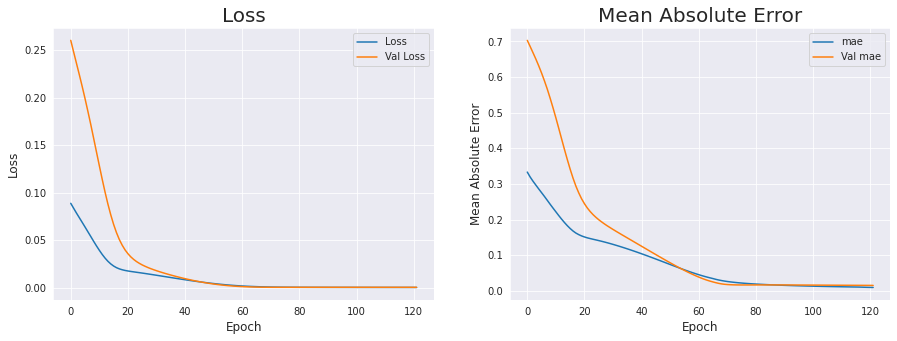

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

# Predict

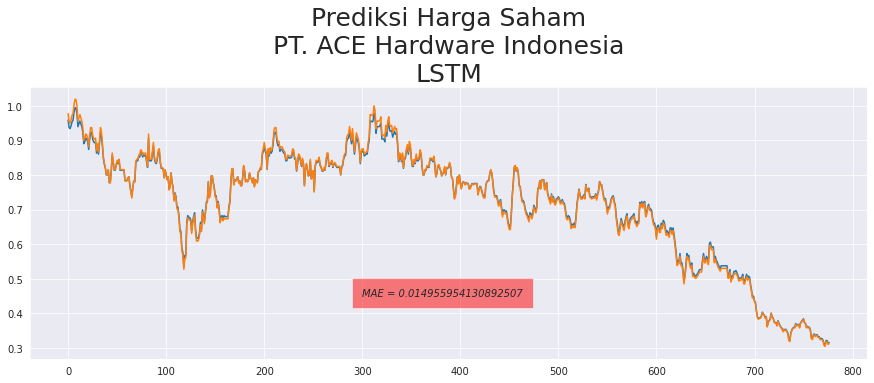

In [17]:
plt.figure(figsize=(15,5))
y_pred = model.predict(X_test)
y_pred = list(np.reshape(y_pred, (1,len(y_pred)))[0])

X_test = np.reshape(X_test, (len(X_test),1))
X_test = list(np.reshape(X_test, (1,len(X_test)))[0])

plt.plot(X_test)
plt.plot(y_pred)
plt.text(300, 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.title('Prediksi Harga Saham\nPT. ACE Hardware Indonesia\nLSTM', fontsize=25)
plt.show()